In [1]:
import numpy as np
import matplotlib.pylab as plt
import math
import pandas as pd
import seaborn as sns
sns.set()
from matplotlib import rcParams
rcParams['figure.figsize'] = 11.7,8.27

In [2]:
class RLS_Filter:
    def __init__(self, num_vars, lam, delta):
        '''
        num_vars: Degree of polinomial
        lam: Forgetting factor, usually very close to 1
        delta: Initation value -> ! Bad initation needs more itteration to reach same accuracy
        '''
        self.num_vars = num_vars
        self.P = delta*np.matrix(np.identity(self.num_vars))

        # Weigths/Coefficent of the system
        self.w = np.matrix(np.zeros(self.num_vars))
        self.w = self.w.reshape(self.w.shape[1],1)

        # Kalman Gain Factor
        self.g = np.matrix(np.zeros(num_vars))
        self.g = np.reshape(self.g,(num_vars,1))
        
        # Variables needed for add_obs
        self.lam_inv = lam**(-1)
        
        # A priori error
        self.a_priori_error = 0
        
        # Count of number of observations added
        self.num_obs = 0

    def add_obs(self, x, t):
        '''
        Expected value is t, add the new observation as t.
        t is noisy output of the some linear system. Input of the RLS.

        Task is to identify a system, by determining coefficents,
        that outputs a value which is closest to t.

        x is a column vector as a numpy matrix  |   (new inputs to the system)
        t is a real scalar                      |   (expected output to update weigths)
        '''            

        self.g = self.lam_inv*self.P*x/(1+self.lam_inv*(x.T*self.P*x))
        self.P = self.P*self.lam_inv - self.g*(x.T*self.P)
        self.w = self.w + self.g*(t-x.T*self.w)

        self.a_priori_error = t - x.T*self.w
        self.num_obs += 1
        

    def get_error(self):
        '''
        Finds the (instantaneous) error.
        '''
        return self.a_priori_error

    def get_weights(self):
        '''
        Finds the (instantaneous) weigths.
        '''
        return self.w

In [4]:
##
##  Input Signal with a memory Generation Block
##

#Initate the system input parameters
mem_len = 2
Degree = 5
coefficent_matrix = np.zeros((mem_len,Degree))
avilable_input = np.zeros((mem_len))

# Sample Cooefficent Matrix
coefficent_matrix[mem_len-1]   = [0.07, -1.9, 4.1, -10, 5]
coefficent_matrix[mem_len-2] = [0.05, -2.6, -5.0, -14, -9]

#Initate the input array with correct dimensions
for i in range(mem_len):
    avilable_input[i] = i

#Create and update pure signal
def update_signal(x,coefficent_matrix,test_size):
    mem_dim = np.shape(coefficent_matrix)[0]
    degree_dim = np.shape(coefficent_matrix)[1]
    c = np.zeros((mem_dim,degree_dim))

    every_input = [0]
    every_pure_input = []

    for n in range(test_size):
        acc = 0
        c = np.sin(x*np.pi/5)
        for m in range(mem_dim):
            for k in range(degree_dim):
                acc = acc + coefficent_matrix[m][k]*(c[m]**k)
                #print(acc,"k =",k,"c=",c[m],"c[m]**k",c[m]**k)
        #avilable_input = avilable_input + 1
        #print("Input no[{}]-->".format(n), acc)


        
        acc = acc + 0.5*np.random.normal(0,2,1)[0]
        x = x + 1
        every_input.append(acc)
        every_pure_input.append(c)
    
    line_refernce = np.linspace(0,test_size,test_size)
    plt.step(line_refernce,every_pure_input[0:test_size],label='Input Signals Before The Channels')    
    plt.step(line_refernce,every_input[0:test_size],label='Input Signals After The Channels')       
    plt.legend(["Pure","After Channels"])

    return every_input,every_pure_input


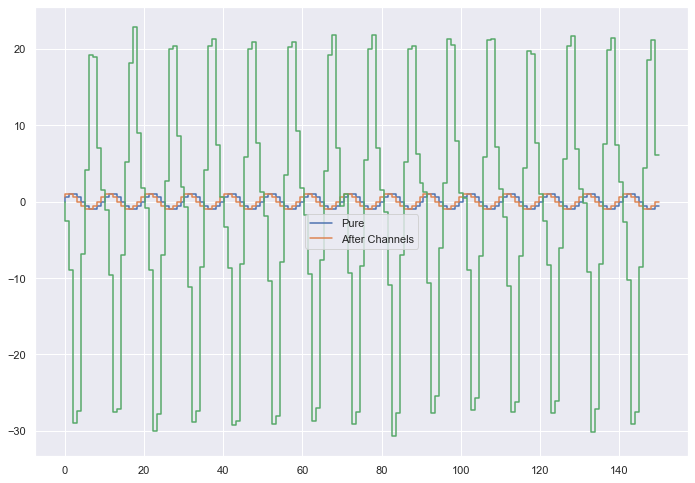

In [5]:
every_input,every_pure_input = update_signal(x=avilable_input,coefficent_matrix=coefficent_matrix,test_size=150)

In [6]:
def gen_regs(x_val,deg,mem_len,prediction):
    regs = np.zeros((mem_len,deg))

    assert np.shape(x_val)      ==  (2,)
    assert np.shape(prediction) ==  (deg,)

    for j in range (mem_len):
        for k in range (deg):
            regs[j][k] = x_val[j]**prediction[k]

    return regs

In [40]:
def one_batch(deg,mem_len,prediction,LS_2,test_size):
        # Gets the result of the algorithm that has the data of {test_size} according to given predictions (prediction,mem_len,deg)
    
    """""
    test_size   -- Number of measurements availble
    prediction  -- Prediction of Regressors (Closer Prediction gives better results)
    every_pure_input -- Input measurments with memory
    LS_2        -- Main Object
    deg & mem_len   -- Prediction of degree and memory length of the system
    """""

    assert LS_2.__class__.__name__  == "RLS_Filter"                     
    assert np.shape(prediction)     == (deg,)                    
    assert np.shape(every_pure_input)    == (test_size,mem_len)
    
    num_vars  = deg*mem_len

    pred_e = []
    pred_output = []

    for i in range(test_size):

        regs = gen_regs(x_val=every_pure_input[i][:],deg=deg,mem_len=mem_len,prediction=prediction)
        regs = regs.flatten()
        regs = np.reshape(1,num_vars)
        
        LS_2.add_obs(x=regs.T,t=every_input[i])
        #Single RLS Data has been evaluated

        pred_e.append(LS_2.get_error())     
        #To observe if the error is in fact decreasing

        get_weigths = LS_2.get_weights()
        #print(get_weigths)

        pred_output.append(regs*get_weigths)

    return pred_e,pred_output

In [41]:
lam = 0.98
deg = 5
mem_len = 2
num_vars =deg*mem_len
test_size = 150 
prediction = [0,1,2,3,4]
LS_2 = RLS_Filter(num_vars,lam,1)


pred_e, pred_output = one_batch(test_size = test_size, deg = 5, mem_len = 2,prediction = prediction,LS_2= LS_2)

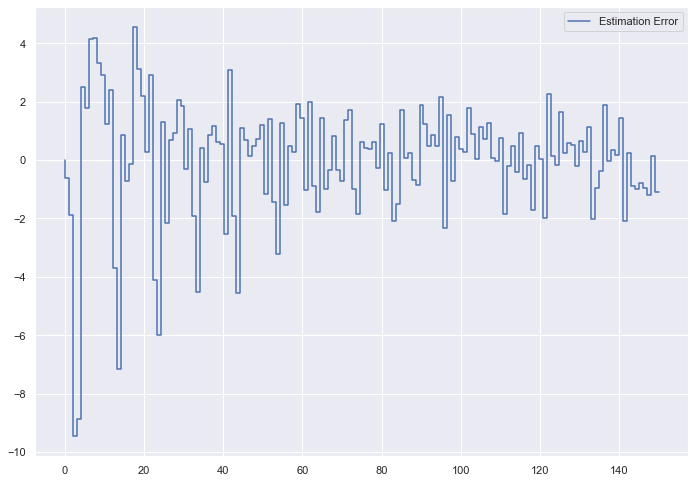

In [42]:
line_refernce = np.linspace(0,test_size,test_size)
plt.step(line_refernce,np.squeeze(pred_e)[0:test_size],    label='Estimation Error')  
#plt.step(line_refernce,np.squeeze(every_pure_input).T[0:test_size][0],label='Pure_Input')      
#plt.step(line_refernce, every_input[0:test_size],label='Curropted Signal') 
#plt.step(line_refernce,every_input[0:test_size],label='Input Signals After The Channels')       
plt.legend()

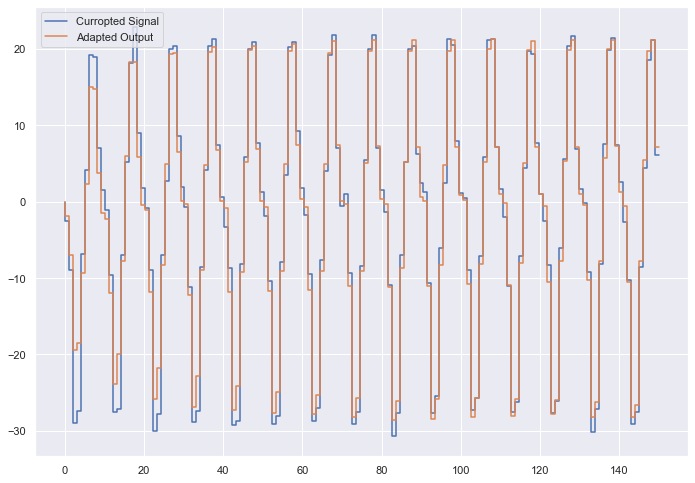

In [43]:
line_refernce = np.linspace(0,test_size,test_size) 
plt.step(line_refernce,every_input[0:test_size],label='Curropted Signal') 
plt.step(line_refernce,np.squeeze(pred_output)[0:test_size],label='Adapted Output')       
plt.legend()

In [37]:
reg_trails = 10
rndm_preds = np.zeros((reg_trails ,deg))

for i in range(deg):
    rndm_preds[0][i] = i

for k in range (1,reg_trails):
    for i in range(deg):
        if i < deg-1:
            rndm_preds[k][i] = rndm_preds[k-1][i+1]
        else:
            rndm_preds[k][i] = rndm_preds[k-1][i]+1

C:\Users\Enes\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:6: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  


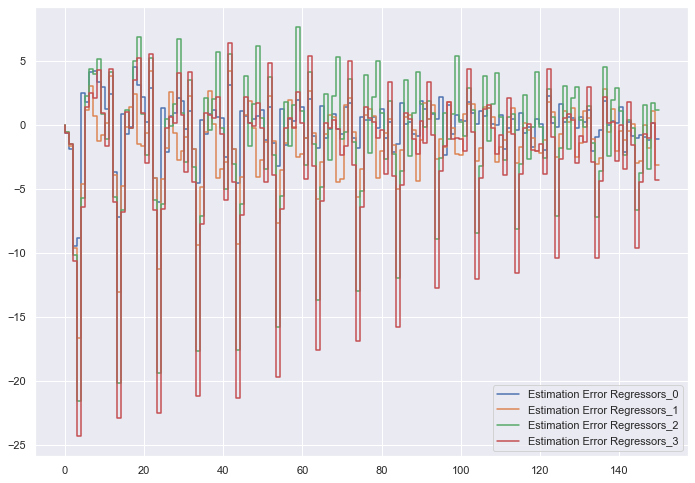

In [50]:
pred_e = np.zeros((reg_trails,test_size))
pred_output = np.zeros((reg_trails,test_size ))

for j in range (reg_trails):
    LS_2 = RLS_Filter(num_vars,lam,1)
    pred_e[j], pred_output[j] = one_batch(test_size = test_size, deg = 5, mem_len = 2,prediction = rndm_preds[j],LS_2= LS_2)


line_refernce = np.linspace(0,test_size,test_size)
for j in range (0,4):
    plt.step(line_refernce,np.squeeze(pred_e[j])[0:test_size],    label='Estimation Error Regressors_{}'.format(j))  
#plt.step(line_refernce,np.squeeze(every_pure_input).T[0:test_size][0],label='Pure_Input')      
#plt.step(line_refernce, every_input[0:test_size],label='Curropted Signal') 
#plt.step(line_refernce,every_input[0:test_size],label='Input Signals After The Channels')       
plt.legend()

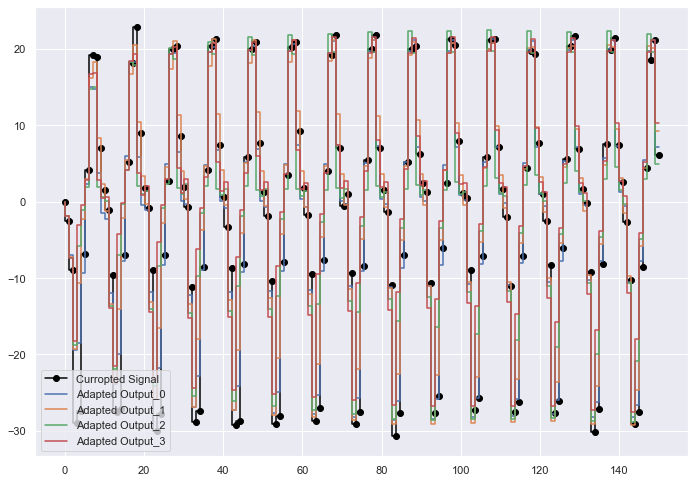

In [65]:
plt.step(line_refernce,every_input[0:test_size],label='Curropted Signal',color='black', marker='o')
for j in range (4):
    plt.step(line_refernce,np.squeeze(pred_output[j])[0:test_size],    label='Adapted Output_{}'.format(j))  
#plt.step(line_refernce,np.squeeze(every_pure_input).T[0:test_size][0],label='Pure_Input')      
#plt.step(line_refernce, every_input[0:test_size],label='Curropted Signal') 
#plt.step(line_refernce,every_input[0:test_size],label='Input Signals After The Channels')       
plt.legend()